# Grade Regression Using Transformer Model

## Creating the Datasets

### Loading and cleaning the data

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

seed=42

os.chdir('/home/jovyan/shared/2020_06_10_bad_reviewer')

In [2]:
reviewer_df = pd.read_csv('results/reviewer_agg_stats.csv', index_col=[0])
cleared_submissions = pd.read_csv('bin/cleared_submissions.csv')
submissions_df = pd.read_csv('bin/submissions_df.csv', index_col=[0])
reviews_df = pd.read_csv('bin/reviews_df.csv', index_col = [0])

# Rename the columns to disambiguate whether the id represents a reviewer or an author
submissions_df = submissions_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_author'})
reviewer_df = reviewer_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_reviewer'})
reviews_df = reviews_df.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_reviewer'})
cleared_submissions = cleared_submissions.rename(columns={'uva_peer_assignments_user_id':'uva_peer_assignments_user_id_author'})

# Get the author id into reviews_df
reviews_df = pd.merge(reviews_df, cleared_submissions[['peer_submission_id', 'uva_peer_assignments_user_id_author']], on='peer_submission_id', how="left")
# Note that authors could only be found for 864,073 out of the 1,059,044 reviews.
reviews_df.count()

peer_review_id                                             1084657
uva_peer_assignments_user_id_reviewer                      1084657
peer_review_created_ts                                     1084657
peer_submission_id                                         1084657
peer_assignment_review_schema_part_prompt_score             929706
peer_assignment_review_schema_part_option_score             929706
peer_assignment_review_schema_part_prompt_free_response    1084640
peer_review_part_free_response_text                        1059044
uva_peer_assignments_user_id_author                         864073
dtype: int64

In [3]:
# Find duplicate essays
print(len(submissions_df))
submissions_df['is_duplicate'] = submissions_df.duplicated(subset=['text'], keep=False)
texts = submissions_df[submissions_df['is_duplicate']==False][['uva_peer_assignments_user_id_author', 'text']]

texts

27909


,uva_peer_assignments_user_id_author,text
0,0000e5af02da0c7575b3ebd346b55b29f959e90f,Reflection – visualization\n\nChallenge &...
1,0002c0f31f5c8456bd360dfcd089a64f444e2de0,Assignment :\n\n1. Challenge: Describe your ch...
2,00030b378ea62d60a177113b7854eb26cc29e1a9,VISUALIZATION\n\nChallenge I am part of the...
3,000458f7d47a0b6414f9146258829170ae3ed6a9,The main item is usually the focal point of th...
4,00069909160c6bcd9836cdb23e35b1fdaf56d0c3,Storytelling is when narratives people tell ab...
...,...,...
28342,fff43ee22d85efffada33d73f953c0d814d90290,Peter Vogt - Design Thinking Reflection - Lear...
28343,fff56a1858c62540bd76bad23db07a2fbfa963fe,STORYTELLING AS A TOOL FOR STRATEGIC CHANGES\n...
28344,fff7364558963fb9fa218f2fa08d5d2767992207,Junio 2019 Storytelling Jose Vergara\n\nChalle...
28345,fffa6add42713b8b1e2a5158616f780997bbda49,Reflexion - Mind Mapping\n\nChallenge & Select...


In [4]:
# Get rid of duplicate reviews
reviews_df.drop(list(range(755643, 755650)), axis=0, inplace=True)
reviews_df.drop(list(range(1025262, 1025269)), axis=0, inplace=True)

In [5]:
# Get number of words for the labelled texts
texts['num_words'] = texts.apply(lambda row: len(row['text'].split()), axis=1)

# Get reviewer variance
reviewer_df['total_variance'] = reviewer_df['total_sd']**2
texts

,uva_peer_assignments_user_id_author,text,num_words
0,0000e5af02da0c7575b3ebd346b55b29f959e90f,Reflection – visualization\n\nChallenge &...,583
1,0002c0f31f5c8456bd360dfcd089a64f444e2de0,Assignment :\n\n1. Challenge: Describe your ch...,1003
2,00030b378ea62d60a177113b7854eb26cc29e1a9,VISUALIZATION\n\nChallenge I am part of the...,627
3,000458f7d47a0b6414f9146258829170ae3ed6a9,The main item is usually the focal point of th...,215
4,00069909160c6bcd9836cdb23e35b1fdaf56d0c3,Storytelling is when narratives people tell ab...,1070
...,...,...,...
28342,fff43ee22d85efffada33d73f953c0d814d90290,Peter Vogt - Design Thinking Reflection - Lear...,496
28343,fff56a1858c62540bd76bad23db07a2fbfa963fe,STORYTELLING AS A TOOL FOR STRATEGIC CHANGES\n...,779
28344,fff7364558963fb9fa218f2fa08d5d2767992207,Junio 2019 Storytelling Jose Vergara\n\nChalle...,802
28345,fffa6add42713b8b1e2a5158616f780997bbda49,Reflexion - Mind Mapping\n\nChallenge & Select...,807


In [81]:
reviewer_df#['uva_peer_assignments_user_id_reviewer'].nunique()

,uva_peer_assignments_user_id_reviewer,num_reviews,criteria_mean,criteria_sd,total_mean,total_sd,total_tokens,total_types,total_ttr,response_tokens,response_types,response_ttr,num_responses,solo_reviews,response_ratio,total_variance
0,0000e5af02da0c7575b3ebd346b55b29f959e90f,3.0,2.111111,0.669706,12.666667,2.624669,367,180,0.490463,17.476190,15.142857,0.914908,21,0,1.0,6.888889
1,0002c0f31f5c8456bd360dfcd089a64f444e2de0,3.0,2.000000,0.471405,12.000000,2.828427,323,150,0.464396,15.380952,14.238095,0.934807,21,0,1.0,8.000000
2,00030b378ea62d60a177113b7854eb26cc29e1a9,3.0,2.111111,0.581785,12.666667,3.299832,73,28,0.383562,3.476190,3.476190,1.000000,21,0,1.0,10.888889
3,000458f7d47a0b6414f9146258829170ae3ed6a9,3.0,3.000000,0.000000,18.000000,0.000000,42,2,0.047619,2.000000,2.000000,1.000000,21,0,1.0,0.000000
4,00069909160c6bcd9836cdb23e35b1fdaf56d0c3,3.0,2.166667,0.372678,13.000000,0.000000,35,11,0.314286,1.666667,1.666667,1.000000,21,0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41238,fff56a1858c62540bd76bad23db07a2fbfa963fe,3.0,1.888889,0.290893,11.333333,4.784233,261,127,0.486590,12.428571,11.285714,0.949896,21,0,1.0,22.888889
41239,fff7364558963fb9fa218f2fa08d5d2767992207,3.0,2.722222,0.323802,16.333333,1.247219,151,82,0.543046,7.190476,7.000000,0.986317,21,0,1.0,1.555556
41240,fff883a717a37b5699e5105a96d61dc10812cabe,4.0,3.000000,0.000000,18.000000,0.000000,28,1,0.035714,1.000000,1.000000,1.000000,28,1,1.0,0.000000
41241,fffa6add42713b8b1e2a5158616f780997bbda49,3.0,2.444444,0.490468,14.666667,0.471405,145,89,0.613793,6.904762,6.761905,0.993266,21,0,1.0,0.222222


Text(0, 0.5, 'Average Reviewer Score')

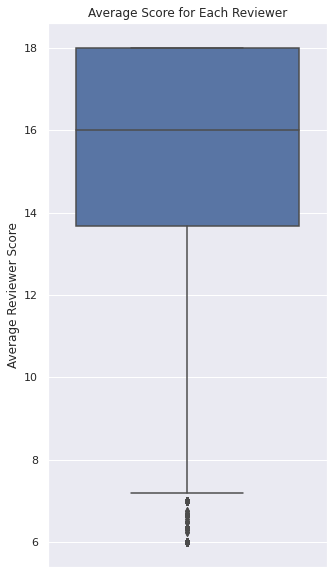

In [62]:
import seaborn as sns

sns.set_theme()
plt.figure(figsize=(5,10))
sns.boxplot(data=reviewer_df, y='total_mean')
plt.title('Average Score for Each Reviewer')
plt.ylabel('Average Reviewer Score')

### Create Ten Dataframes

#### Define function

In [6]:
### Include All Reviewers
def generateDF(good_reviewers):
    labelled_data = texts.merge(reviews_df, on='uva_peer_assignments_user_id_author', how='left')
    print(len(texts), len(set(labelled_data['uva_peer_assignments_user_id_author'])))

    # essay_scores contains, author id, reviewer id, submission id, and the sum score for each review
    essay_scores = labelled_data.groupby(['uva_peer_assignments_user_id_reviewer', 'peer_submission_id', 'uva_peer_assignments_user_id_author']).agg({'peer_assignment_review_schema_part_option_score':'sum'}).reset_index()
    # Merge essay scores with good reviewers and keep only reviews by good reviewers
    essay_scores_good_reviewers = good_reviewers.merge(essay_scores, on='uva_peer_assignments_user_id_reviewer', how='right')
    essay_scores_good_only = essay_scores_good_reviewers[essay_scores_good_reviewers['good_reviewer'] == True]
    # Create a dataframe of submission ids of submissions reviewed by at least two good reviewers
    good_reviewers_df = essay_scores_good_only.groupby('peer_submission_id').agg({'good_reviewer':'sum'}).reset_index()
    good_reviewers_df = good_reviewers_df[good_reviewers_df['good_reviewer'] >= 2].rename(columns={'good_reviewer':'num_reviews'})
    # Merge essay scores with good reviewers in order to remove submissions with less than two good reviewers
    essay_scores_good_labelled = essay_scores_good_only.merge(good_reviewers_df, on='peer_submission_id', how='right')
    # Collect average scores for each submission
    essay_scores_final = essay_scores_good_labelled.groupby(['peer_submission_id', 'uva_peer_assignments_user_id_author']).agg({'peer_assignment_review_schema_part_option_score':'mean'}).reset_index()
    return essay_scores_final.merge(texts, on='uva_peer_assignments_user_id_author')[['text','peer_assignment_review_schema_part_option_score']].rename(columns = {'peer_assignment_review_schema_part_option_score':'labels'})

#### Baseline - All Reviewers

In [7]:
good_reviewers = reviewer_df[reviewer_df['total_variance']>=0][['uva_peer_assignments_user_id_reviewer']]
good_reviewers['good_reviewer'] = True

baseline = generateDF(good_reviewers)


22903 22903


           num_words    labels
num_words   1.000000  0.164521
labels      0.164521  1.000000


Text(0.5, 1.0, 'Correlation between Essay Score and Number of Words')

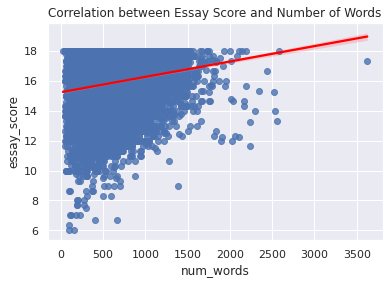

In [79]:
baseline['num_words'] = baseline.apply(lambda row: len(row['text'].split()), axis=1)
print(baseline[['num_words', 'labels']].corr())

sns.regplot(data=baseline, x='num_words', y='labels', line_kws={"color": "red"})
plt.ylabel('essay_score')
plt.title('Correlation between Essay Score and Number of Words')
#baseline[['num_words', 'labels']].plot.scatter('num_words', 'labels')

#### variance1 - Above Zero

In [9]:
good_reviewers = reviewer_df[reviewer_df['total_variance']>0][['uva_peer_assignments_user_id_reviewer']]
good_reviewers['good_reviewer'] = True

variance1 = generateDF(good_reviewers)
len(variance1)

22903 22903


19336

In [10]:
# variance1['num_words'] = variance1.apply(lambda row: len(row['text'].split()), axis=1)
# variance1[['num_words', 'labels']].corr().iloc[(0,1)]

#### variance2 - Above 1

In [11]:
good_reviewers = reviewer_df[reviewer_df['total_variance']>1][['uva_peer_assignments_user_id_reviewer']]
good_reviewers['good_reviewer'] = True

variance2 = generateDF(good_reviewers)
len(variance2)

22903 22903


12574

In [12]:
# variance2['num_words'] = variance2.apply(lambda row: len(row['text'].split()), axis=1)
# variance2[['num_words', 'labels']].corr().iloc[(0,1)]

#### variance3 - Above 2.75

In [13]:
good_reviewers = reviewer_df[reviewer_df['total_variance']>2.75][['uva_peer_assignments_user_id_reviewer']]
good_reviewers['good_reviewer'] = True

variance3 = generateDF(good_reviewers)
len(variance3)

22903 22903


8066

In [14]:
# variance3['num_words'] = variance3.apply(lambda row: len(row['text'].split()), axis=1)
# variance3[['num_words', 'labels']].corr().iloc[(0,1)]

#### ttr1 - Above 0.05

In [15]:
good_reviewers = reviewer_df[reviewer_df['total_ttr']>0.05][['uva_peer_assignments_user_id_reviewer']]
good_reviewers['good_reviewer'] = True

ttr1 = generateDF(good_reviewers)
len(ttr1)

22903 22903


21157

In [16]:
# ttr1['num_words'] = ttr1.apply(lambda row: len(row['text'].split()), axis=1)
# ttr1[['num_words', 'labels']].corr().iloc[(0,1)]

#### ttr2 - Above 0.2

In [17]:
good_reviewers = reviewer_df[reviewer_df['total_ttr']>0.2][['uva_peer_assignments_user_id_reviewer']]
good_reviewers['good_reviewer'] = True

ttr2 = generateDF(good_reviewers)
len(ttr2)

22903 22903


16875

In [18]:
# ttr2['num_words'] = ttr2.apply(lambda row: len(row['text'].split()), axis=1)
# ttr2[['num_words', 'labels']].corr().iloc[(0,1)]

#### ttr3 - Above 0.4

In [19]:
good_reviewers = reviewer_df[reviewer_df['total_ttr']>0.4][['uva_peer_assignments_user_id_reviewer']]
good_reviewers['good_reviewer'] = True

ttr3 = generateDF(good_reviewers)
len(ttr3)

22903 22903


11234

In [20]:
# ttr3['num_words'] = ttr3.apply(lambda row: len(row['text'].split()), axis=1)
# ttr3[['num_words', 'labels']].corr().iloc[(0,1)]

#### ttr_v0 - TTR above 0.05 or variance above 0
(pay no attention to the broken numbering scheme)

In [21]:
good_reviewers = reviewer_df[(reviewer_df['total_ttr']>=0.05)|(reviewer_df['total_variance'] >0)][['uva_peer_assignments_user_id_reviewer']]
good_reviewers['good_reviewer'] = True

ttr_v0 = generateDF(good_reviewers)
len(ttr_v0)

22903 22903


22244

In [22]:
# ttr_v0['num_words'] = ttr_v0.apply(lambda row: len(row['text'].split()), axis=1)
# ttr_v0[['num_words', 'labels']].corr().iloc[(0,1)]

#### ttr_v1 - TTR above 0.4 or variance above 0

In [23]:
good_reviewers = reviewer_df[(reviewer_df['total_ttr']>=0.4)|(reviewer_df['total_variance'] >0)][['uva_peer_assignments_user_id_reviewer']]
good_reviewers['good_reviewer'] = True

ttr_v1 = generateDF(good_reviewers)
len(ttr_v1)

22903 22903


20209

In [24]:
# ttr_v1['num_words'] = ttr_v1.apply(lambda row: len(row['text'].split()), axis=1)
# ttr_v1[['num_words', 'labels']].corr().iloc[(0,1)]

#### ttr_v2 - TTR above 0.4 or variance above 2.5

In [25]:
good_reviewers = reviewer_df[(reviewer_df['total_ttr']>=0.4)|(reviewer_df['total_variance'] >2.5)][['uva_peer_assignments_user_id_reviewer']]
good_reviewers['good_reviewer'] = True

ttr_v2 = generateDF(good_reviewers)
len(ttr_v2)

22903 22903


16116

In [26]:
# ttr_v2['num_words'] = ttr_v2.apply(lambda row: len(row['text'].split()), axis=1)
# ttr_v2[['num_words', 'labels']].corr().iloc[(0,1)]

#### Check the shapes to make sure they look good

In [27]:
print(baseline.shape)
print(variance1.shape)
print(variance2.shape)
print(variance3.shape)
print(ttr1.shape)
print(ttr2.shape)
print(ttr3.shape)
print(ttr_v0.shape)
print(ttr_v1.shape)
print(ttr_v2.shape)

(22871, 2)
(19336, 2)
(12574, 2)
(8066, 2)
(21157, 2)
(16875, 2)
(11234, 2)
(22244, 2)
(20209, 2)
(16116, 2)


## Build the HuggingFace Models
### Load the packages

In [28]:
%%capture

!pip install datasets
import numpy as np
import pandas as pd

from datasets import load_dataset, load_metric, Dataset, Value, ClassLabel, Features, DatasetDict
from transformers import pipeline
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

from huggingface_hub import notebook_login

### Build the Datasets

#### Let's do it with a function

In [29]:
def buildDataset(df):
    full_dataset = Dataset.from_pandas(df)
    # 70% train, 30% test + validation
    train_testvalid = full_dataset.train_test_split(test_size=0.3, seed=seed)
    # Split the 30% test + valid in half test, half valid
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
    # gather everyone if you want to have a single DatasetDict
    final_dataset = DatasetDict({
        'train': train_testvalid['train'],
        'test': test_valid['test'],
        'valid': test_valid['train']})
    return final_dataset

#### Rock and roll

In [30]:
baseline_ds = buildDataset(baseline)
var1_ds = buildDataset(variance1)
var2_ds = buildDataset(variance2)
var3_ds = buildDataset(variance3)
ttr1_ds = buildDataset(ttr1)
ttr2_ds = buildDataset(ttr2)
ttr3_ds = buildDataset(ttr3)
ttv0_ds = buildDataset(ttr_v0)
ttv1_ds = buildDataset(ttr_v1)
ttv2_ds = buildDataset(ttr_v2)

#### Check it out

In [31]:
# Check them one by one
print(baseline_ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 16009
    })
    test: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 3431
    })
    valid: Dataset({
        features: ['text', 'labels', '__index_level_0__'],
        num_rows: 3431
    })
})


## Build the Models

### Instantiate the tokenizer and model

In [32]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

In [33]:
def model_init():
  return AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased",
                                                            num_labels=1).to("cuda")

### Tokenize the text

In [34]:
def tokenize_inputs(example):
    return tokenizer(example['text'], truncation = True)

In [35]:
%%capture

#do the tokenizing using map function
baseline_ds_t = baseline_ds.map(tokenize_inputs, batched=True, remove_columns=['text', '__index_level_0__'])
var1_ds_t = var1_ds.map(tokenize_inputs, batched=True, remove_columns=['text', '__index_level_0__'])
var2_ds_t = var2_ds.map(tokenize_inputs, batched=True, remove_columns=['text', '__index_level_0__'])
var3_ds_t = var3_ds.map(tokenize_inputs, batched=True, remove_columns=['text', '__index_level_0__'])
ttr1_ds_t = ttr1_ds.map(tokenize_inputs, batched=True, remove_columns=['text', '__index_level_0__'])
ttr2_ds_t = ttr2_ds.map(tokenize_inputs, batched=True, remove_columns=['text', '__index_level_0__'])
ttr3_ds_t = ttr3_ds.map(tokenize_inputs, batched=True, remove_columns=['text', '__index_level_0__'])
ttv0_ds_t = ttv0_ds.map(tokenize_inputs, batched=True, remove_columns=['text', '__index_level_0__'])
ttv1_ds_t = ttv1_ds.map(tokenize_inputs, batched=True, remove_columns=['text', '__index_level_0__'])
ttv2_ds_t = ttv2_ds.map(tokenize_inputs, batched=True, remove_columns=['text', '__index_level_0__'])

#### Check it out

In [36]:
ttv2_ds_t

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 11281
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2418
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2417
    })
})

### Instantiate Data Collator

In [37]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Function to Compute Metrics

In [38]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    #labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

## Now for the Main Event...

### Train the Models

In [39]:
trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir ='./results/baseline_checkpoints',          
    num_train_epochs = 16,     
    per_device_train_batch_size = 64,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs/baseline',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed
) 

# Call the Trainer
baseline_trainer = Trainer(
    model_init = model_init,                         
    args = training_args,
    data_collator=data_collator,
    train_dataset = baseline_ds_t['train'],         
    eval_dataset = baseline_ds_t['valid'],          
    compute_metrics = compute_metrics_for_regression,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
baseline_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,2.596475,2.596475,1.611358,1.296656,0.010474,28754.231419
2,23.812400,2.573072,2.573072,1.604080,1.277858,0.019393,28819.765666
3,23.812400,2.801305,2.801305,1.673710,1.292676,-0.067588,29024.415039
4,2.771200,2.626308,2.626308,1.620589,1.310401,-0.000896,30139.413582
5,2.771200,2.675890,2.675890,1.635815,1.299092,-0.019791,30219.045176


TrainOutput(global_step=1255, training_loss=11.104735063651644, metrics={'train_runtime': 1026.5096, 'train_samples_per_second': 249.529, 'train_steps_per_second': 3.912, 'total_flos': 1.060316382967296e+16, 'train_loss': 11.104735063651644, 'epoch': 5.0})

In [40]:
# Variance 1

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir ='./results/var1_checkpoints',          
    num_train_epochs = 16,     
    per_device_train_batch_size = 64,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs/var1',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed
) 

# Call the Trainer
var1_trainer = Trainer(
    model_init = model_init,                         
    args = training_args,
    data_collator=data_collator,
    train_dataset = var1_ds_t['train'],         
    eval_dataset = var1_ds_t['valid'],          
    compute_metrics = compute_metrics_for_regression,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
var1_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,3.075973,3.075973,1.753845,1.384564,0.059350,28388.960000
2,No log,3.009088,3.009089,1.734672,1.359841,0.079804,28881.975172
3,22.023400,2.960974,2.960974,1.720748,1.351057,0.094518,29128.551724
4,22.023400,3.078734,3.078734,1.754632,1.363505,0.058506,29220.402759
5,3.043100,3.103946,3.103946,1.761802,1.384781,0.050796,30942.518621
6,3.043100,3.334890,3.334890,1.826168,1.438789,-0.019828,32157.282759


TrainOutput(global_step=1272, training_loss=10.409610292446688, metrics={'train_runtime': 1044.9252, 'train_samples_per_second': 207.249, 'train_steps_per_second': 3.246, 'total_flos': 1.075748559694848e+16, 'train_loss': 10.409610292446688, 'epoch': 6.0})

In [41]:
# Variance 2

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir ='./results/var2_checkpoints',          
    num_train_epochs = 16,     
    per_device_train_batch_size = 64,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs/var2',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed
) 

# Call the Trainer
var2_trainer = Trainer(
    model_init = model_init,                         
    args = training_args,
    data_collator=data_collator,
    train_dataset = var2_ds_t['train'],         
    eval_dataset = var2_ds_t['valid'],          
    compute_metrics = compute_metrics_for_regression,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
var2_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,6.332610,6.332610,2.516468,2.127351,-0.485983,27727.410392
2,No log,3.881926,3.881926,1.970260,1.575226,0.089084,23360.360551
3,No log,3.792858,3.792858,1.947526,1.569380,0.109985,23284.572641
4,21.526200,3.733534,3.733534,1.932235,1.528168,0.123905,23117.096501
5,21.526200,3.941460,3.941460,1.985311,1.550804,0.075114,23283.476140
6,21.526200,3.825573,3.825574,1.955907,1.543411,0.102308,23859.003181
7,21.526200,4.438028,4.438028,2.106663,1.631076,-0.041408,24200.307529


TrainOutput(global_step=966, training_loss=12.718498530101579, metrics={'train_runtime': 794.8201, 'train_samples_per_second': 177.167, 'train_steps_per_second': 2.778, 'total_flos': 8160773490594816.0, 'train_loss': 12.718498530101579, 'epoch': 7.0})

In [42]:
# Variance 3

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir ='./results/var3_checkpoints',          
    num_train_epochs = 16,     
    per_device_train_batch_size = 64,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs/var3',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed
) 

# Call the Trainer
var3_trainer = Trainer(
    model_init = model_init,                         
    args = training_args,
    data_collator=data_collator,
    train_dataset = var3_ds_t['train'],         
    eval_dataset = var3_ds_t['valid'],          
    compute_metrics = compute_metrics_for_regression,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
var3_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,30.804693,30.804693,5.550198,5.100112,-4.619622,48714.839669
2,No log,4.884197,4.884197,2.210022,1.768287,0.108988,17199.322314
3,No log,4.770918,4.770918,2.184243,1.747135,0.129654,16476.745455
4,No log,4.557712,4.557713,2.134880,1.697001,0.168548,16935.128926
5,No log,5.312137,5.312137,2.304807,1.752648,0.030920,17229.993388
6,22.045500,4.800717,4.800717,2.191054,1.685926,0.124217,17489.623140
7,22.045500,4.797024,4.797024,2.190211,1.712387,0.124891,18250.099174


TrainOutput(global_step=623, training_loss=18.451473083006245, metrics={'train_runtime': 513.0748, 'train_samples_per_second': 176.068, 'train_steps_per_second': 2.775, 'total_flos': 5235283164174336.0, 'train_loss': 18.451473083006245, 'epoch': 7.0})

In [43]:
# TTR 1

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir ='./results/ttr1_checkpoints',          
    num_train_epochs = 16,     
    per_device_train_batch_size = 64,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs/ttr1',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed
) 

# Call the Trainer
ttr1_trainer = Trainer(
    model_init = model_init,                         
    args = training_args,
    data_collator=data_collator,
    train_dataset = ttr1_ds_t['train'],         
    eval_dataset = ttr1_ds_t['valid'],          
    compute_metrics = compute_metrics_for_regression,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
ttr1_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,2.998424,2.998424,1.731596,1.369655,0.019029,28839.639572
2,No log,2.908523,2.908522,1.705439,1.359761,0.048441,29626.444865
3,23.603900,2.921589,2.921589,1.709266,1.345180,0.044167,29998.041588
4,23.603900,2.888181,2.888181,1.699465,1.345181,0.055096,29967.241336
5,3.097300,2.916701,2.916701,1.707835,1.342039,0.045766,29955.246377
6,3.097300,3.127331,3.127331,1.768426,1.380756,-0.023145,30863.074984
7,2.564600,3.509334,3.509334,1.873322,1.435338,-0.148122,31486.260870


TrainOutput(global_step=1624, training_loss=9.16849966941796, metrics={'train_runtime': 1333.6897, 'train_samples_per_second': 177.661, 'train_steps_per_second': 2.783, 'total_flos': 1.3731723056722944e+16, 'train_loss': 9.16849966941796, 'epoch': 7.0})

In [44]:
# TTR 2

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir ='./results/ttr2_checkpoints',          
    num_train_epochs = 16,     
    per_device_train_batch_size = 64,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs/ttr2',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed
) 

# Call the Trainer
ttr2_trainer = Trainer(
    model_init = model_init,                         
    args = training_args,
    data_collator=data_collator,
    train_dataset = ttr2_ds_t['train'],         
    eval_dataset = ttr2_ds_t['valid'],          
    compute_metrics = compute_metrics_for_regression,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
ttr2_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,3.433192,3.433192,1.852888,1.516515,-0.009984,26245.773212
2,No log,3.227482,3.227482,1.796519,1.388970,0.050532,25815.908337
3,22.834300,3.078017,3.078017,1.754428,1.393559,0.094502,25840.497827
4,22.834300,3.130857,3.130857,1.769423,1.375614,0.078957,26307.092849
5,22.834300,3.255595,3.255595,1.804327,1.393707,0.042262,26175.988937
6,2.959000,3.490071,3.490071,1.868173,1.424559,-0.026717,26311.050178


TrainOutput(global_step=1110, training_loss=11.867857264613246, metrics={'train_runtime': 912.6117, 'train_samples_per_second': 207.089, 'train_steps_per_second': 3.243, 'total_flos': 9388062051803136.0, 'train_loss': 11.867857264613246, 'epoch': 6.0})

In [45]:
# TTR 3

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir ='./results/ttr3_checkpoints',          
    num_train_epochs = 16,     
    per_device_train_batch_size = 64,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs/ttr3',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed
) 

# Call the Trainer
ttr3_trainer = Trainer(
    model_init = model_init,                         
    args = training_args,
    data_collator=data_collator,
    train_dataset = ttr3_ds_t['train'],         
    eval_dataset = ttr3_ds_t['valid'],          
    compute_metrics = compute_metrics_for_regression,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
ttr3_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,12.710691,12.710690,3.565206,3.204593,-2.485219,38156.776261
2,No log,3.332324,3.332324,1.825465,1.429976,0.086291,17234.369139
3,No log,3.292742,3.292742,1.814592,1.431637,0.097144,18980.430861
4,No log,3.323823,3.323823,1.823136,1.398344,0.088621,18249.753116
5,22.536500,3.788747,3.788747,1.946470,1.569863,-0.038859,20397.581009
6,22.536500,3.499324,3.499324,1.870648,1.432982,0.040500,19008.715727


TrainOutput(global_step=738, training_loss=16.196726067602473, metrics={'train_runtime': 610.1909, 'train_samples_per_second': 206.178, 'train_steps_per_second': 3.225, 'total_flos': 6249435481995264.0, 'train_loss': 16.196726067602473, 'epoch': 6.0})

In [46]:
# TTV 0

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir ='./results/ttv0_checkpoints',          
    num_train_epochs = 16,     
    per_device_train_batch_size = 64,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs/ttv0',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed
) 

# Call the Trainer
ttv0_trainer = Trainer(
    model_init = model_init,                         
    args = training_args,
    data_collator=data_collator,
    train_dataset = ttv0_ds_t['train'],         
    eval_dataset = ttv0_ds_t['valid'],          
    compute_metrics = compute_metrics_for_regression,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
ttv0_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,3.053164,3.053164,1.747331,1.361699,-0.051179,29709.348517
2,No log,2.796978,2.796978,1.672417,1.344327,0.037024,30277.686545
3,23.567500,2.835213,2.835213,1.683809,1.331175,0.023860,30770.486065
4,23.567500,2.928007,2.928007,1.711142,1.337436,-0.008089,30248.841474
5,3.041900,2.959799,2.959799,1.720407,1.358086,-0.019035,31459.934073


TrainOutput(global_step=1220, training_loss=11.419583329998078, metrics={'train_runtime': 1001.5991, 'train_samples_per_second': 248.722, 'train_steps_per_second': 3.898, 'total_flos': 1.03124030750208e+16, 'train_loss': 11.419583329998078, 'epoch': 5.0})

In [47]:
# TTV 1

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir ='./results/ttv1_checkpoints',          
    num_train_epochs = 16,     
    per_device_train_batch_size = 64,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs/ttv1',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed
) 

# Call the Trainer
ttv1_trainer = Trainer(
    model_init = model_init,                         
    args = training_args,
    data_collator=data_collator,
    train_dataset = ttv1_ds_t['train'],         
    eval_dataset = ttv1_ds_t['valid'],          
    compute_metrics = compute_metrics_for_regression,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
ttv1_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,2.931199,2.931199,1.712075,1.376218,0.070421,29176.485648
2,No log,2.873404,2.873404,1.695112,1.360700,0.088750,29864.102936
3,22.510900,2.879410,2.879410,1.696882,1.357183,0.086845,29832.662488
4,22.510900,2.922643,2.922643,1.709574,1.321979,0.073135,29450.230287
5,2.989300,3.233368,3.233368,1.798157,1.371410,-0.025406,30159.216100


TrainOutput(global_step=1110, training_loss=11.772999064127605, metrics={'train_runtime': 910.9803, 'train_samples_per_second': 248.453, 'train_steps_per_second': 3.899, 'total_flos': 9369252016650240.0, 'train_loss': 11.772999064127605, 'epoch': 5.0})

In [48]:
# TTV 2

trainer = Trainer(
    model_init=model_init,
)

training_args = TrainingArguments(
    output_dir ='./results/ttv2_checkpoints',          
    num_train_epochs = 16,     
    per_device_train_batch_size = 64,   
    per_device_eval_batch_size = 20,   
    weight_decay = 0.01,               
    learning_rate = 2e-5,
    logging_dir = './logs/ttv2',            
    save_total_limit = 10,
    load_best_model_at_end = True,     
    metric_for_best_model = 'rmse',    
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    greater_is_better = False,
    seed=seed
) 

# Call the Trainer
ttv2_trainer = Trainer(
    model_init = model_init,                         
    args = training_args,
    data_collator=data_collator,
    train_dataset = ttv2_ds_t['train'],         
    eval_dataset = ttv2_ds_t['valid'],          
    compute_metrics = compute_metrics_for_regression,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
ttv2_trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,3.544342,3.544342,1.882642,1.508490,0.043040,25420.655358
2,No log,3.347013,3.347013,1.829484,1.422277,0.096318,25512.506413
3,22.355000,3.233019,3.233019,1.798060,1.411720,0.127096,26981.211419
4,22.355000,3.405169,3.405169,1.845310,1.394202,0.080616,26559.329748
5,22.355000,3.370639,3.370639,1.835930,1.401462,0.089939,26440.345883
6,3.233100,3.681979,3.681979,1.918848,1.499873,0.005878,29287.847745


TrainOutput(global_step=1062, training_loss=12.209099979723915, metrics={'train_runtime': 873.1678, 'train_samples_per_second': 206.714, 'train_steps_per_second': 3.243, 'total_flos': 8966028446189568.0, 'train_loss': 12.209099979723915, 'epoch': 6.0})

## Analysis of the Models

### Evaluate the Models Based on the Training Metrics

In [49]:
def outputMetrics(metric_dict):
    print('{},{},{},{}'.format(metric_dict['eval_mse'],metric_dict['eval_rmse'],metric_dict['eval_mae'],metric_dict['eval_r2']))

print(outputMetrics(baseline_trainer.evaluate()))
print(outputMetrics(var1_trainer.evaluate()))
print(outputMetrics(var2_trainer.evaluate()))
print(outputMetrics(var3_trainer.evaluate()))
print(outputMetrics(ttr1_trainer.evaluate()))
print(outputMetrics(ttr2_trainer.evaluate()))
print(outputMetrics(ttr3_trainer.evaluate()))
print(outputMetrics(ttv0_trainer.evaluate()))
print(outputMetrics(ttv1_trainer.evaluate()))
print(outputMetrics(ttv2_trainer.evaluate()))


2.5730717182159424,1.6040797233581543,1.277857780456543,0.019392819047388987
None


2.9609739780426025,1.7207480669021606,1.351056694984436,0.09451762929823626
None


3.733534097671509,1.9322354793548584,1.5281683206558228,0.12390517917848531
None


4.557712554931641,2.1348800659179688,1.6970010995864868,0.16854813740368224
None


2.888181209564209,1.699465036392212,1.3451813459396362,0.055096362803320975
None


3.078017234802246,1.7544279098510742,1.3935585021972656,0.0945019645522488
None


3.2927422523498535,1.8145915269851685,1.4316368103027344,0.09714366698313515
None


2.7969775199890137,1.6724166870117188,1.344327449798584,0.0370236905180259
None


2.873403549194336,1.695111632347107,1.360700011253357,0.088750295147766
None


3.233018636703491,1.7980597019195557,1.4117201566696167,0.12709621362513135
None


### Get Predictions on the Test Groups

In [50]:
from matplotlib import pyplot as plt

baseline_preds = baseline_trainer.predict(baseline_ds_t['test'])
baseline_predictions = [i[0] for i in list(baseline_preds.predictions)]
baseline_labels = list(baseline_preds.label_ids)

var1_preds = var1_trainer.predict(var1_ds_t['test'])
var1_predictions = [i[0] for i in list(var1_preds.predictions)]
var1_labels = list(var1_preds.label_ids)

var2_preds = var2_trainer.predict(var2_ds_t['test'])
var2_predictions = [i[0] for i in list(var2_preds.predictions)]
var2_labels = list(var2_preds.label_ids)

var3_preds = var2_trainer.predict(var3_ds_t['test'])
var3_predictions = [i[0] for i in list(var3_preds.predictions)]
var3_labels = list(var3_preds.label_ids)

ttr1_preds = ttr1_trainer.predict(ttr1_ds_t['test'])
ttr1_predictions = [i[0] for i in list(ttr1_preds.predictions)]
ttr1_labels = list(ttr1_preds.label_ids)

ttr2_preds = ttr2_trainer.predict(ttr2_ds_t['test'])
ttr2_predictions = [i[0] for i in list(ttr2_preds.predictions)]
ttr2_labels = list(ttr2_preds.label_ids)

ttr3_preds = ttr3_trainer.predict(ttr3_ds_t['test'])
ttr3_predictions = [i[0] for i in list(ttr3_preds.predictions)]
ttr3_labels = list(ttr3_preds.label_ids)

ttv0_preds = ttv0_trainer.predict(ttv0_ds_t['test'])
ttv0_predictions = [i[0] for i in list(ttv0_preds.predictions)]
ttv0_labels = list(ttv0_preds.label_ids)

ttv1_preds = ttv1_trainer.predict(ttv1_ds_t['test'])
ttv1_predictions = [i[0] for i in list(ttv1_preds.predictions)]
ttv1_labels = list(ttv1_preds.label_ids)

ttv2_preds = ttv2_trainer.predict(ttv2_ds_t['test'])
ttv2_predictions = [i[0] for i in list(ttv2_preds.predictions)]
ttv2_labels = list(ttv2_preds.label_ids)

### Graph the Predicted and Actual Scores for Each Model

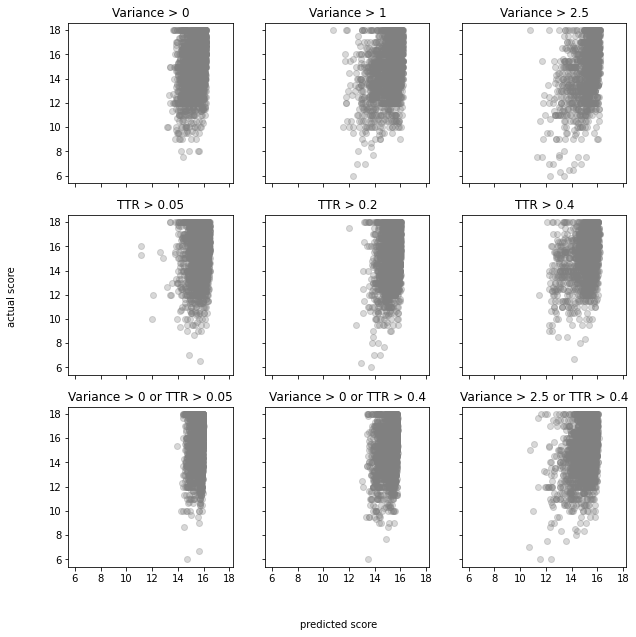

In [54]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))

axs[0, 0].scatter(var1_predictions, var1_labels, color='gray', alpha=0.3)
axs[0, 0].set_title("Variance > 0")
axs[0, 1].scatter(var2_predictions, var2_labels, color='gray', alpha=0.3)
axs[0, 1].set_title("Variance > 1")
axs[0, 2].scatter(var3_predictions, var3_labels, color='gray', alpha=0.3)
axs[0, 2].set_title("Variance > 2.5")
axs[1, 0].scatter(ttr1_predictions, ttr1_labels, color='gray', alpha=0.3)
axs[1, 0].set_title("TTR > 0.05")
axs[1, 1].scatter(ttr2_predictions, ttr2_labels, color='gray', alpha=0.3)
axs[1, 1].set_title("TTR > 0.2")
axs[1, 2].scatter(ttr3_predictions, ttr3_labels, color='gray', alpha=0.3)
axs[1, 2].set_title("TTR > 0.4")
axs[2, 0].scatter(ttv0_predictions, ttv0_labels, color='gray', alpha=0.3)
axs[2, 0].set_title("Variance > 0 or TTR > 0.05")
axs[2, 1].scatter(ttv1_predictions, ttv1_labels, color='gray', alpha=0.3)
axs[2, 1].set_title("Variance > 0 or TTR > 0.4")
axs[2, 2].scatter(ttv2_predictions, ttv2_labels, color='gray', alpha=0.3)
axs[2, 2].set_title("Variance > 2.5 or TTR > 0.4")

plt.xlim([5.5, 18.25])
plt.xticks(np.arange(6, 19, step=2)) 
fig.text(0.5, 0.04, 'predicted score', ha='center')
fig.text(0.04, 0.5, 'actual score', va='center', rotation='vertical')
fig.show()

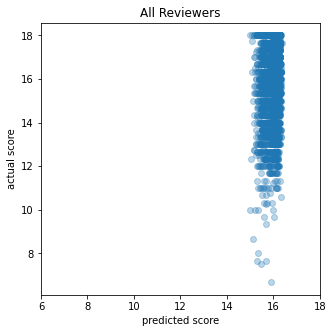

In [52]:
plt.figure(figsize=(5,5))
plt.scatter(baseline_predictions, baseline_labels, alpha=0.3)
plt.title('All Reviewers')
plt.xlabel('predicted score')
plt.ylabel('actual score')
plt.xlim([14, 18])
plt.xticks(np.arange(6, 19, step=2)) 
plt.show()

### Get the Inferential Stats

In [53]:
from scipy.stats import pearsonr 
r, p = pearsonr(baseline_predictions, baseline_labels)
p = round(p, 3)
print(f'all reviewers,{r},{p}')

r, p = pearsonr(var1_predictions, var1_labels)
p = round(p, 3)
print(f'variance > 0,{r},{p}')

r, p = pearsonr(var2_predictions, var2_labels)
p = round(p, 3)
print(f'Variance > 1,{r},{p}')

r, p = pearsonr(var3_predictions, var3_labels)
p = round(p, 3)
print(f'Variance > 2.5,{r},{p}')

r, p = pearsonr(ttr1_predictions, ttr1_labels)
p = round(p, 3)
print(f'TTR > 0.05,{r},{p}')

r, p = pearsonr(ttr2_predictions, ttr2_labels)
p = round(p, 3)
print(f'TTR > 0.2,{r},{p}')

r, p = pearsonr(ttr3_predictions, ttr3_labels)
p = round(p, 3)
print(f'TTR > 0.4,{r},{p}')

r, p = pearsonr(ttv0_predictions, ttv0_labels)
p = round(p, 3)
print(f'Variance > 0 or TTR > 0.05,{r},{p}')

r, p = pearsonr(ttv1_predictions, ttv1_labels)
p = round(p, 3)
print(f'Variance > 0 or TTR > 0.4,{r},{p}')

r, p = pearsonr(ttv2_predictions, ttv2_labels)
p = round(p, 3)
print(f'Variance > 2.5 or TTR > 0.4,{r},{p}')

all reviewers,0.19194023558164683,0.0
variance > 0,0.32045108463551353,0.0
Variance > 1,0.3596498327238653,0.0
Variance > 2.5,0.45591454883299465,0.0
TTR > 0.05,0.1893233205784435,0.0
TTR > 0.2,0.3065462116213772,0.0
TTR > 0.4,0.33457079514667815,0.0
Variance > 0 or TTR > 0.05,0.21650842309067225,0.0
Variance > 0 or TTR > 0.4,0.2812200833429934,0.0
Variance > 2.5 or TTR > 0.4,0.3580720699061372,0.0
